# 2. Data fetching and processing

In [60]:
import sys
from pathlib import Path
sys.path.append(str(Path("../../").resolve()))

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## More details about list_data

In [19]:
import pipeGEM as pg
from pipeGEM.data.fetching import list_models, load_model

In [8]:
model_list = list_models(organism="human")

In [9]:
model_list

,id,organism,reaction_count,metabolite_count,gene_count,database
1,Human-GEM,Homo sapiens,13078,8370,3625,metabolic atlas
1,iAB_RBC_283,Homo sapiens,469,342,346,BiGG
12,iAT_PLT_636,Homo sapiens,1008,738,636,BiGG
105,RECON1,Homo sapiens,3741,2766,1905,BiGG
106,Recon3D,Homo sapiens,10600,5835,2248,BiGG


In [12]:
# select by number of components

model_list = list_models(organism="mouse", max_n_genes=2000, max_n_mets=3000, max_n_rxns=5000)

In [13]:
model_list

,id,organism,reaction_count,metabolite_count,gene_count,database
77,iMM1415,Mus musculus,3726,2775,1375,BiGG


## Generate simulated gene data

In [29]:
from pipeGEM.data.synthesis import get_syn_gene_data
import seaborn as sns
import numpy as np

In [20]:
mouse = load_model('iMM1415')

Output()

No objective coefficients in model. Unclear what should be optimized


In [42]:
raw_count = get_syn_gene_data(mouse, n_sample=9)

In [43]:
raw_count.head()

,sample_0,sample_1,sample_2,sample_3,sample_4,sample_5,sample_6,sample_7,sample_8
12846,4031,4175,4187,4184,3982,4048,4098,4095,4093
67689,4207,4008,4199,4088,4077,4101,4070,4086,4017
237940,4056,4129,4050,4078,4147,4053,4085,4113,4173
222,4160,4030,4138,4034,4063,4063,4107,4045,4106
76507,4072,4245,4157,4012,4180,4153,4033,4095,4119


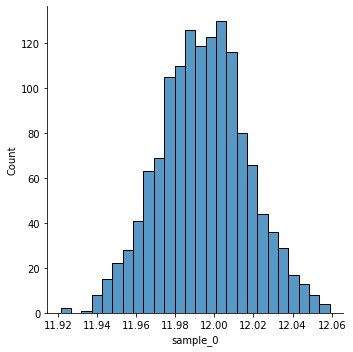

In [45]:
# should be negative binomial distribution

sns.displot(np.log2(raw_count + 1)["sample_0"])

## Maping data to the model

In [78]:
from pipeGEM.integration.mapping import Expression

In [80]:
mapper_0 = Expression(mouse, np.log2(raw_count + 1)["sample_0"])

In [89]:
np.log2(raw_count + 1)["sample_0"]

12846     11.977280
67689     12.038919
237940    11.986198
222       12.022715
76507     11.991876
            ...    
30955     11.981924
18709     12.002463
20975     11.963619
320634    12.024793
269437    11.972262
Name: sample_0, Length: 1375, dtype: float64

In [92]:
mapper_0.get_rxn_score('2AMADPTm')

12.001760028327217

In [99]:
n_exp = 0
for i, score in mapper_0.rxn_scores.items():
    if not np.isnan(score):
        n_exp += 1
        print(i, score)
        
    if n_exp > 20:
        break

2HBt2 11.982637133669424
2HCO3_NAt 12.019590728357882
2OXOADOXm 11.943979914343739
2OXOADPTm 12.001760028327217
34DHPHAMT 11.977279923499916
34DHALDD 12.038918989292302
34DHPLACOX_NADP 12.038918989292302
34DHXMANDACOX 12.038918989292302
34DHXMANDACOX_NADP 12.038918989292302
34HPPOR 12.003869231979056
3AIBTm 11.992230264965889
3DSPHR 11.978352958165143
3HAO 12.053247125912426
3HBCDm 12.03376711484639
13DAMPPOX 11.991876099003415
3HCO3_NAt 12.019590728357882
3HKYNAKGAT 12.032734528586714
3HLYTCL 12.01262453886506
3HPCOAHYD 11.971902746045467
3HXKYNDCL 12.01262453886506
24_25VITD2Hm 11.992230264965889


In [ ]:
dataset_name = "mmusculus_gene_ensembl"
from_id = "entrezgene_id"

## Translate gene ID

## Visualize gene data

In [62]:
from pipeGEM.plotting.heatmap import plot_clustermap
from pipeGEM.plotting.scatter import plot_PCA, plot_embedding

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


saving  None


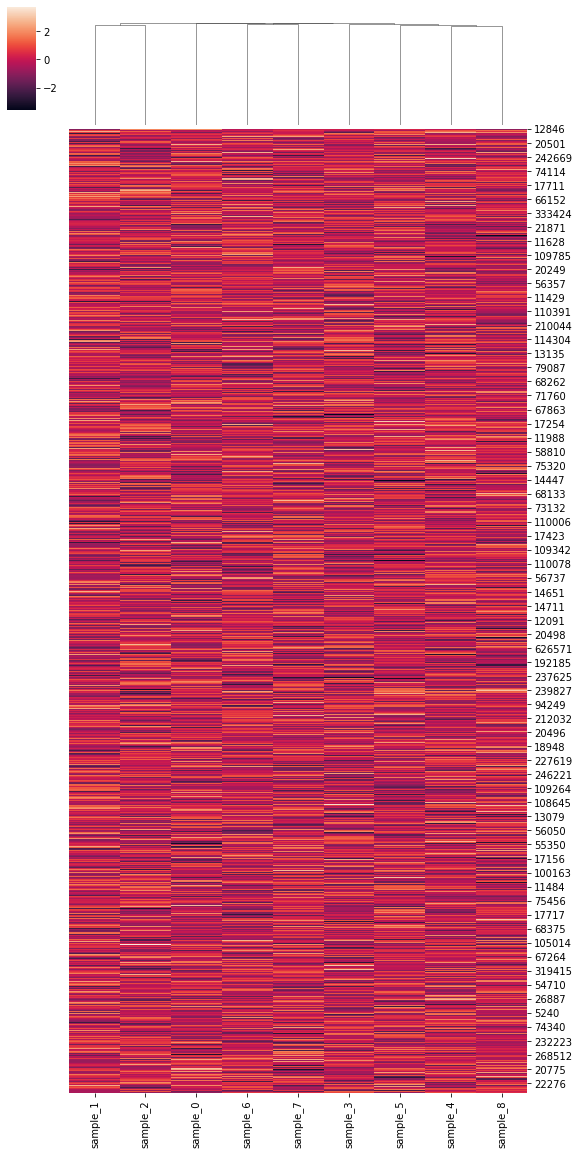

{'g': <seaborn.matrix.ClusterGrid at 0x7fdf23547dd8>}

In [49]:
plot_clustermap(np.log2(raw_count + 1), z_score=1, fig_size=(8, 16))

saving  None


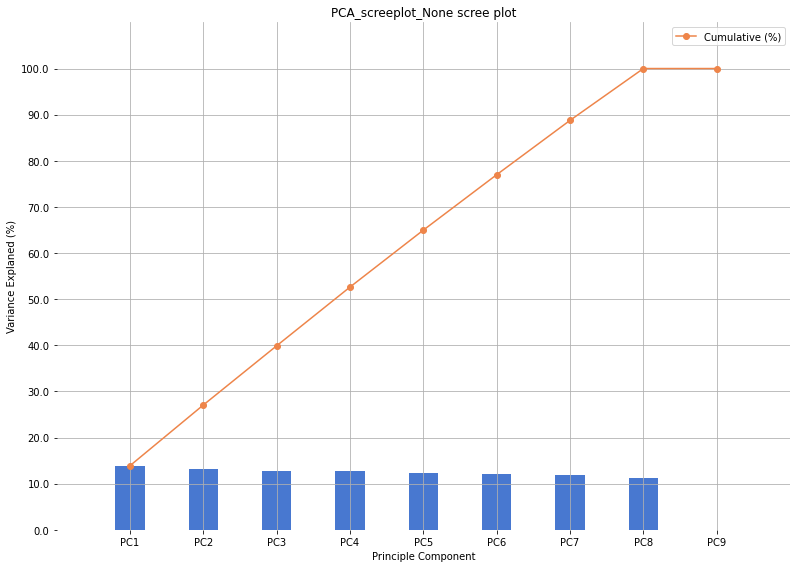

saving  None


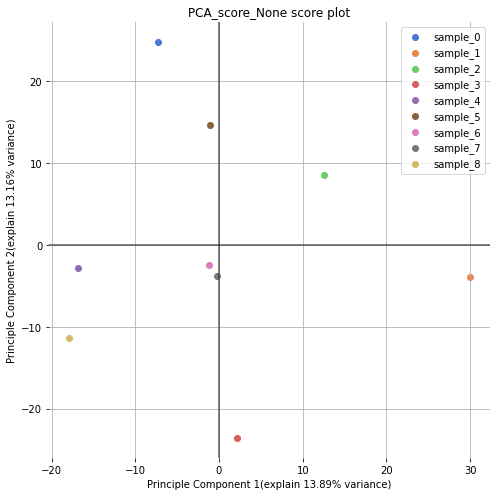

,sample_0,sample_1,sample_2,sample_3,sample_4,sample_5,sample_6,sample_7,sample_8
PC1,-7.283753e+00,2.993887e+01,1.256727e+01,2.100835e+00,-1.684806e+01,-1.065181e+00,-1.248895e+00,-2.683707e-01,-1.789272e+01
PC2,2.475850e+01,-3.875667e+00,8.482486e+00,-2.358963e+01,-2.767262e+00,1.462504e+01,-2.441813e+00,-3.778311e+00,-1.141335e+01
PC3,1.462005e+00,-1.077625e+01,-1.515605e+00,-2.302670e+00,-1.219805e+01,-9.521058e+00,2.974654e+01,1.531978e+01,-1.021469e+01
PC4,-7.074154e+00,5.945462e+00,-3.849781e+00,-1.875418e+01,-1.438886e+01,3.555981e+00,-6.823683e+00,1.995312e+01,2.143608e+01
PC5,-4.203679e+00,-1.721807e+01,2.616175e+01,7.181661e+00,-2.304430e+00,-3.953878e+00,-1.526672e+01,1.422627e+01,-4.622902e+00
PC6,2.394294e+01,8.595929e-01,-3.742794e+00,1.339444e+01,-1.862548e+01,-1.467482e+01,-7.245863e+00,-3.513620e+00,9.605601e+00
PC7,-6.140229e+00,-9.715906e+00,-3.241521e+00,1.315624e+01,-1.869973e+01,2.722413e+01,2.534206e+00,-6.536048e+00,1.418864e+00
PC8,5.954909e+00,2.141268e+00,-1.963941e+01,7.902420e+00,4.906015e+00,6.273147e+00,-1.212475e+01,2.075190e+01,-1.616549e+01
PC9,5.697564e-15,5.697564e-15,5.697564e-15,5.697564e-15,5.697564e-15,5.697564e-15,5.697564e-15,5.697564e-15,5.697564e-15


In [54]:
plot_PCA(np.log2(raw_count + 1), groups=None)

saving  None


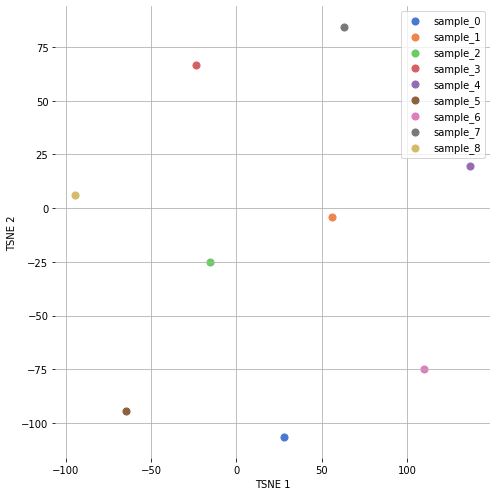

{'g': <Figure size 504x504 with 1 Axes>}

In [65]:
plot_embedding(np.log2(raw_count + 1), reducer="TSNE")

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/umap/umap_.py:2214: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  "n_neighbors is larger than the dataset size; truncating to "


saving  None


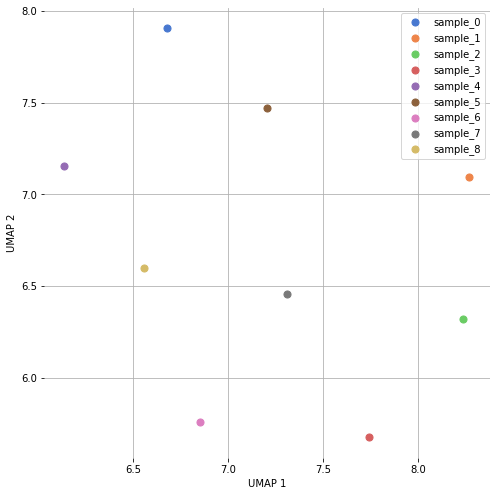

{'g': <Figure size 504x504 with 1 Axes>}

In [64]:
plot_embedding(np.log2(raw_count + 1), reducer="UMAP")

## Protein data fetcher

pipeGEM provides an API to fetch HPA data and to process it,
the data could be found in https://www.proteinatlas.org/about/download

In [66]:
from pipeGEM.pipeline.preprocessing import HPADataFetcher

In [71]:
hpa_data = HPADataFetcher("normal_tissue", data_path="./")

In [73]:
hpa_data()

fetching data...
Data is downloaded and saved in  .
The dataframe is already exist.
[]
Using Fastcormic thresholds
[]
Using Fastcormic thresholds
The dataframe is already exist.
The dataframe is already exist.
[]
Using Fastcormic thresholds
[]
Using Fastcormic thresholds


{'data_df': Empty DataFrame
 Columns: []
 Index: [],
 'used_rxn_thres': None}